In [20]:
# Read Shape files (.shp) with geopandas
# Get .shp files link for the correspondant area at
# http://download.geofabrik.de/ and place it in shape_files
import datetime
import glob
import io
import math
import os
import zipfile
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
from osgeo import gdal
from pymodis import downmodis
from pyproj import Proj

In [2]:
url = "http://download.geofabrik.de/europe/netherlands/gelderland-latest-free.shp.zip"
extraction = "shape_files"
if not os.path.exists(extraction):
    os.makedirs(extraction)

response = requests.get(url)
if response.status_code == 200:
    zipfile = zipfile.ZipFile(io.BytesIO(response.content))
    zipfile.extractall(extraction)
    print("Shape files downloaded")
    print("Shape files are in shape_files")

Shape files downloaded
Shape files are in shape_files


In [11]:
gdf = gpd.read_file("shape_files/gis_osm_natural_free_1.shp")
farthest_west = gdf.geometry.bounds["minx"].idxmin()

# Find the farthest east point
farthest_east = gdf.geometry.bounds["maxx"].idxmax()
farthest_north = gdf.geometry.bounds["maxy"].idxmax()
farthest_south = gdf.geometry.bounds["miny"].idxmin()
west_coordinates = gdf.loc[farthest_west, "geometry"].coords[0]
east_coordinates = gdf.loc[farthest_east, "geometry"].coords[0]
north_coordinates = gdf.loc[farthest_north, "geometry"].coords[0]
south_coordinates = gdf.loc[farthest_south, "geometry"].coords[0]
print("Farthest West Coordinates:", west_coordinates)
print("Farthest East Coordinates:", east_coordinates)
print("Farthest North Coordinates:", north_coordinates)
print("Farthest South Coordinates:", south_coordinates)

Farthest West Coordinates: (5.0115545, 51.8170254)
Farthest East Coordinates: (6.8113423, 51.9661496)
Farthest North Coordinates: (5.867911, 52.5193333)
Farthest South Coordinates: (5.9325433, 51.7422767)


In [3]:
##Read Files using geopandas
print(gdf.head())

     osm_id  code    fclass                        name           type  \
0  24913168  1500  building  Ziekenhuis Gelderse Vallei        parking   
1  31858553  1500  building            Omnisportcentrum  sports_centre   
2  38213496  1500  building              Hervormde Kerk         church   
3  38215717  1500  building          Overbetuwe College         school   
4  38215726  1500  building                         NaN         retail   

                                            geometry  
0  POLYGON ((5.64649 52.02248, 5.64730 52.02259, ...  
1  POLYGON ((5.99530 52.21010, 5.99536 52.21015, ...  
2  POLYGON ((5.89660 51.88767, 5.89666 51.88767, ...  
3  POLYGON ((5.91379 51.89246, 5.91402 51.89255, ...  
4  POLYGON ((5.89785 51.89195, 5.89798 51.89203, ...  


In [15]:
"""""" """
Brief Intro: MODIS assumes the Earth is a sphere
with a R = 6.3781e6 m (6371007.181 m) radius.
The world is subdivided into 18 vertical tiles and 36 horizontal tiles.
each tile has 2400 cells of 500m x 500m.
"""
# Constants
CELLS = 2400
VERTICAL_TILES = 18
HORIZONTAL_TILES = 36
EARTH_RADIUS = 6371007.181
EARTH_WIDTH = 2 * math.pi * EARTH_RADIUS

# Calculate tile and cell sizes
TILE_WIDTH = EARTH_WIDTH / HORIZONTAL_TILES
TILE_HEIGHT = TILE_WIDTH
CELL_SIZE = TILE_WIDTH / CELLS


# Define a projection for the MODIS sinusoidal grid
MODIS_GRID = Proj(f"+proj=sinu +R={EARTH_RADIUS} +nadgrids=@null +wktext")

# Function to convert latitude and longitude to MODIS grid coordinates


def lat_lon_to_modis(lat, lon):
    # Use the MODIS_GRID projection to convert
    # latitude and longitude to x, y coordinates
    x, y = MODIS_GRID(lon, lat)

    # Calculate horizontal and vertical grid indices (h and v)
    h = (EARTH_WIDTH * 0.5 + x) / TILE_WIDTH
    v = -(EARTH_WIDTH * 0.25 + y - (VERTICAL_TILES - 0) * TILE_HEIGHT) / TILE_HEIGHT

    # Return the grid indices as integers
    return int(h), int(v)


# Example usage
x, y = lat_lon_to_modis(51.7422767, 5.9325433)
# 5.0115545, 51.8170254
# 6.8113423, 51.9661496
# 5.9325433, 51.7422767
print(x)
print(y)

18
3


In [63]:
"""""" """
Product must be same name from the list at https://e4ftl01.cr.usgs.gov/MOLT/
""" ""
# Define the parameters
product = "MOD09A1.061"  # e.g., 'MOD09A1'
tiles = "h18v03"  # e.g., 'h17v03,h18v03'
# Gelderland falls in 18th Horizontally and third vertically.
if not os.path.exists("NIR"):
    os.makedirs("NIR")
output_directory = "./NIR/"  # Output Directory
day = "2023-08-01"  # Starting Day
endDate = "2023-08-31"  # Ending Day

# Initialize the downloader
modis_downloader = downmodis.downModis(
    product=product,
    tiles=tiles,
    user="hellium",  # Change to your username
    password="Siksik2010##",  # Change to your password
    destinationFolder=output_directory,
    today=day,
    enddate=endDate,
    jpg=True,
)

# Download the data
modis_downloader.connect()
modis_downloader.downloadsAllDay()

In [64]:
# Get List of Downloaded Files
files = glob.glob(os.path.join(output_directory, "MOD09A1*.hdf"))
# Initialize Dictionary to Store NDVI Values And List to Store Temporal Values
print(output_directory)
tempList = []
NDVI_DICT = {}

for file in files:
    # Get Day Value From Filename
    # Given filename for example is MOD09A1.A2023217.h18v03.061.2023226041025.hdf
    # We want to get the day value of the file
    # So we split the filename on the period and then on the underscore
    # Then we take the second item in the list which is the day value
    # We then convert it to an integer
    # We convert it using datetime using year and day
    # Subtract 1 from the day value to get the correct date
    day_value = int(file.split("/")[-1].split(".")[1][5:])
    year = 2023
    date = datetime.datetime(year, 1, 1) + datetime.timedelta(day_value - 1)
    # Read hdf file and get the red and nir values
    hdf = gdal.Open(file, gdal.GA_ReadOnly)
    # Get the dictionary of hdf metadata
    hdfDict = hdf.GetMetadata("SUBDATASETS")
    # Get the list of hdf metadata keys that contain the name of the hdf file
    hdfList = [hdfDict[k] for k in hdfDict.keys() if "_NAME" in k]
    # Open each hdf file and get the red and nir values
    for n in hdfList:
        tempList.append(gdal.Open(n))
    # RED_VALUES is the first band sur_refl_b01 (620-670 nm)
    RED_VALUES = tempList[0].GetRasterBand(1).ReadAsArray().astype(np.int16)
    # NIR_VALUES is the second band sur_refl_b02 (841-876 nm)
    NIR_VALUES = tempList[1].GetRasterBand(1).ReadAsArray().astype(np.int16)
    # Calculate NDVI Values
    NDVI_VALUES = (NIR_VALUES - RED_VALUES) / (NIR_VALUES + RED_VALUES)
    # Add NDVI Values to Dictionary
    NDVI_DICT[date] = NDVI_VALUES
    # Clear Temp List
    tempList = []
# Sort Dictionary by Key Date
NDVI_DICT = OrderedDict(sorted(NDVI_DICT.items(), key=lambda x: x[0]))
if not os.path.exists("NDVI_Images"):
    os.makedirs("NDVI_Images")

./NIR/


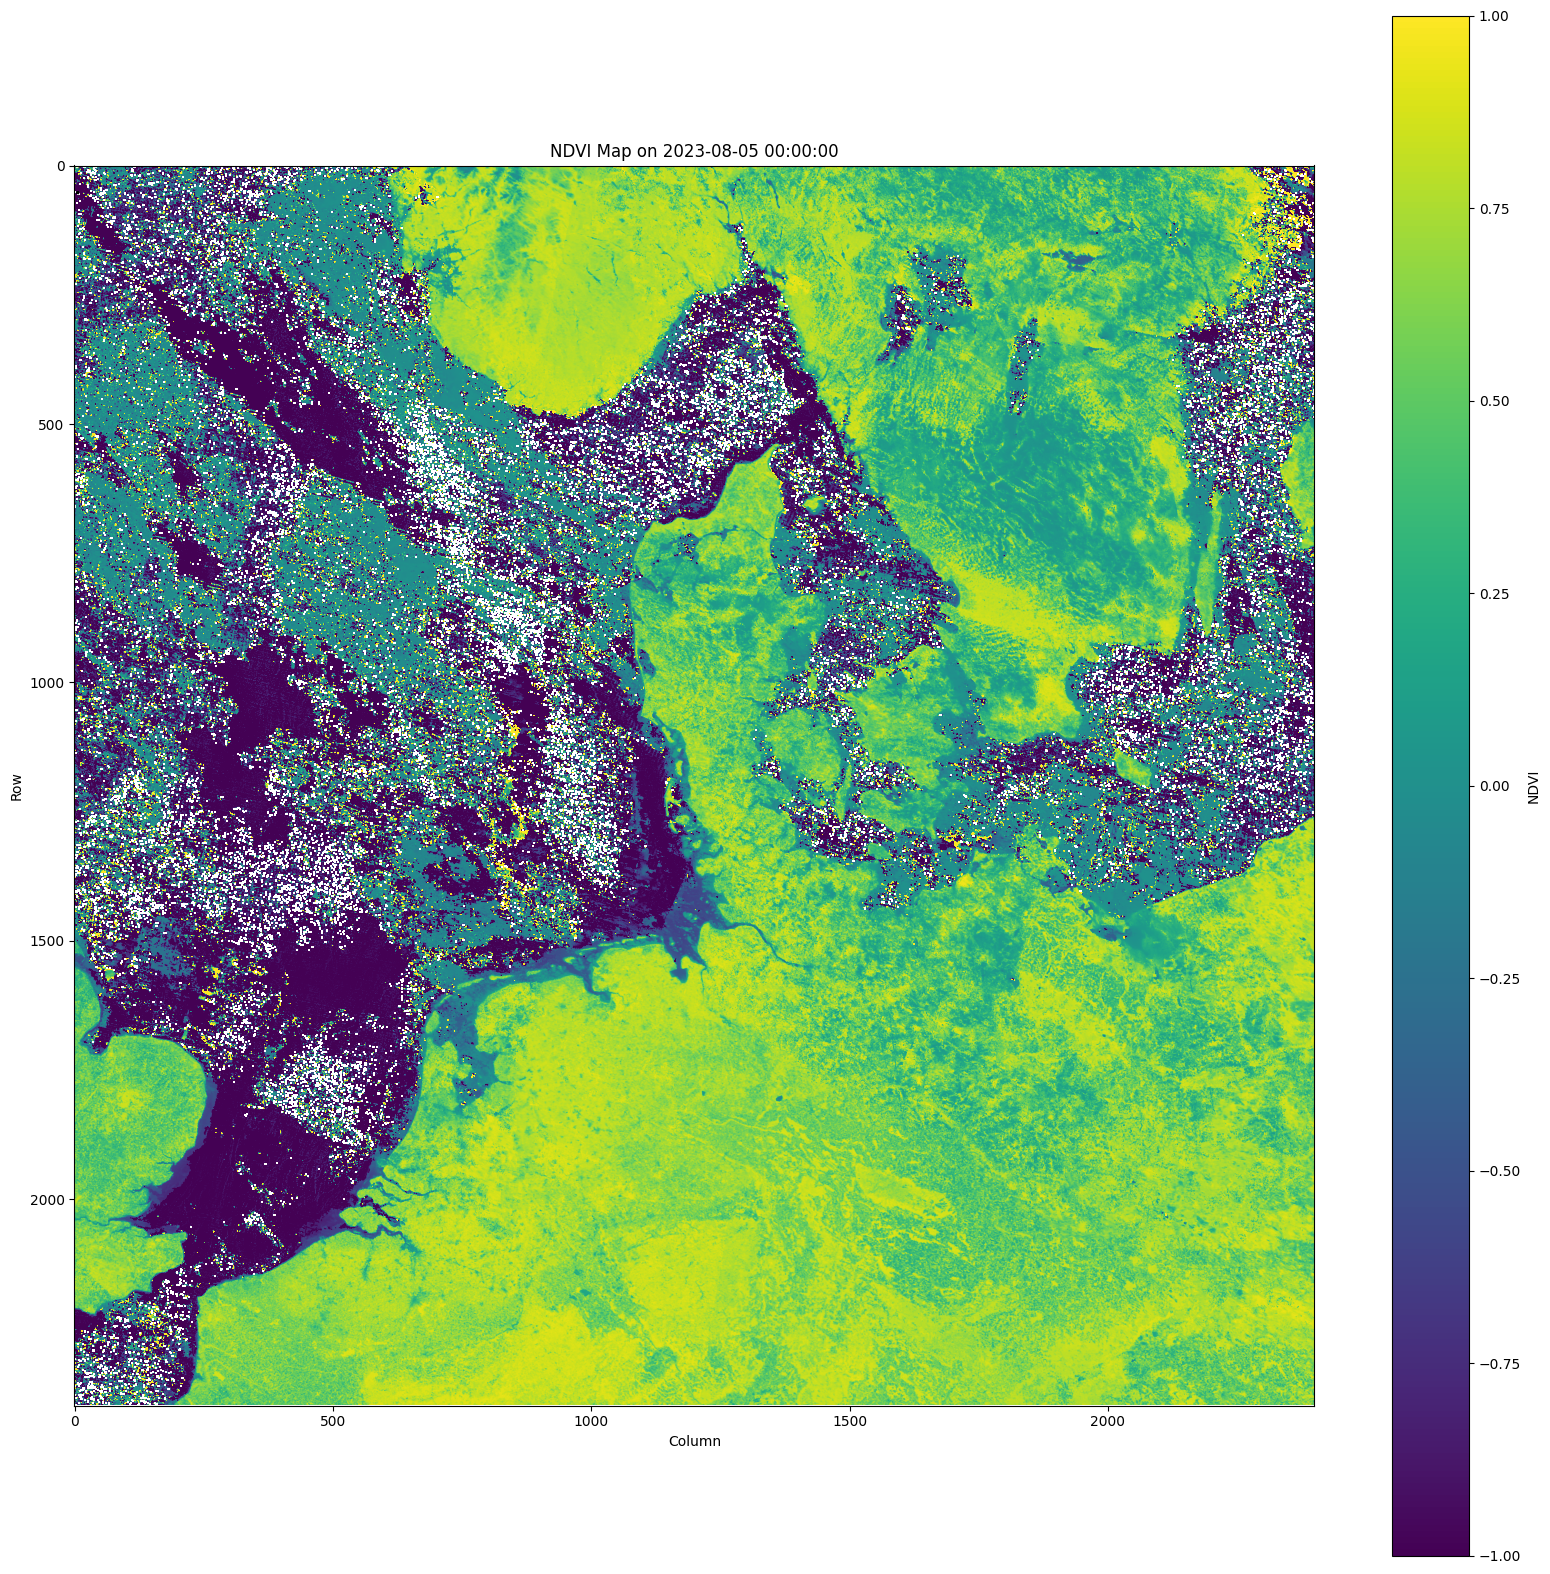

In [65]:
cmap = plt.get_cmap("viridis")
first_item = next(iter(NDVI_DICT.items()))
# Plot the NDVI array
plt.figure(figsize=(20, 20))  # Set the figure size as needed
plt.imshow(
    first_item[1], cmap=cmap, vmin=-1, vmax=1
)  # Set vmin and vmax for the color scale
plt.colorbar(label="NDVI")
plt.title(f"NDVI Map on {first_item[0]}")
plt.xlabel("Column")
plt.ylabel("Row")

# Save the plot as an image (e.g., PNG)
plt.savefig("ndvi_plot.png", dpi=300, bbox_inches="tight")
# Show the plot (you can also save it using plt.savefig)
gdf = gpd.read_file("shape_files/gis_osm_natural_a_free_1.shp")
gdf["geometry"] = gdf["geometry"].buffer(0)
gdf["color"] = "black"
gdf.plot(ax=plt.gca(), facecolor="none", edgecolor="black")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

In [ ]:
def verifyDate(date: str):
    try:
        datetime.datetime.strptime(date, "%Y-%m-%d")
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")


def value_aggregate(dateStart: str, dateEnd: str):
    ##verify date format
    verifyDate(dateStart)
    verifyDate(dateEnd)
    modis_downloader = downmodis.downModis(
        product=product,
        tiles=tiles,
        user="",  # Change to your username
        password="",  # Change to your password
        destinationFolder=output_directory,
        today=dateStart,
        enddate=dateEnd,
    )
    modis_downloader.connect()
    modis_downloader.downloadsAllDay()
    files = glob.glob(os.path.join(output_directory, "MOD09A1*.hdf"))
    # Initialize Dictionary to Store NDVI Values And List to Store Temporal Values
    tempList = []
    NDVI_DICT = {}

    for file in files:
        # Get Day Value From Filename
        # Given filename for example is MOD09A1.A2023217.h18v03.061.2023226041025.hdf
        # We want to get the day value of the file
        # So we split the filename on the period and then on the underscore
        # Then we take the second item in the list which is the day value
        # We then convert it to an integer
        # We convert it using datetime using year and day
        # Subtract 1 from the day value to get the correct date
        day_value = int(file.split("/")[-1].split(".")[1][5:])
        year = 2023
        date = datetime.datetime(year, 1, 1) + datetime.timedelta(day_value - 1)
        # Read hdf file and get the red and nir values
        hdf = gdal.Open(file, gdal.GA_ReadOnly)
        # Get the dictionary of hdf metadata
        hdfDict = hdf.GetMetadata("SUBDATASETS")
        # Get the list of hdf metadata keys that contain the name of the hdf file
        hdfList = [hdfDict[k] for k in hdfDict.keys() if "_NAME" in k]
        # Open each hdf file and get the red and nir values
        for n in hdfList:
            tempList.append(gdal.Open(n))
        # RED_VALUES is the first band sur_refl_b01 (620-670 nm)
        RED_VALUES = tempList[0].GetRasterBand(1).ReadAsArray().astype(np.int16)
        # NIR_VALUES is the second band sur_refl_b02 (841-876 nm)
        NIR_VALUES = tempList[1].GetRasterBand(1).ReadAsArray().astype(np.int16)
        # Calculate NDVI Values
        NDVI_VALUES = (NIR_VALUES - RED_VALUES) / (NIR_VALUES + RED_VALUES)
        # Add NDVI Values to Dictionary
        NDVI_DICT[date] = NDVI_VALUES
        cmap = plt.get_cmap("RdYlGn")
        # Get the first item from the dictionary
        # Plot the NDVI array
        plt.figure(figsize=(10, 10))  # Set the figure size as needed
        plt.imshow(
            NDVI_VALUES, cmap=cmap, vmin=-1, vmax=1
        )  # Set vmin and vmax for the color scale
        plt.colorbar(label="NDVI")
        plt.title(f"NDVI Map on {date}")
        plt.xlabel("Column")
        plt.ylabel("Row")

        # Save the plot as an image (e.g., PNG)
        plt.savefig(f"./NDVI_Images/{date}_ndvi.png", dpi=300, bbox_inches="tight")
        # Clear Temp List
        tempList = []
    # Sort Dictionary by Key Date
    NDVI_DICT = OrderedDict(sorted(NDVI_DICT.items(), key=lambda x: x[0]))